<a href="https://colab.research.google.com/github/OSGeoLabBp/tutorials/blob/master/english/data_processing/lessons/ransac_line.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RANSAC 2D vonal

Ebben a leckében a RANSAC (RANdom SAmple Consensus) módszert mutatjuk be egy egyszerű példán.

RANSAC egy robosztus módszer geometriai elemek megtalálására egy pontfelhőben. Egy vonal megtalálásához egy síkbeli ponthalmazon a következő lépéseket hajtjuk végre.

1. válasszunk ki két pontot véletlenszerűen a ponthalmazból
2. írjuk fel a két ponton átmenő egyenes egyenletét
3. keressük meg a vonal közelébe eső pontokat (eg tolerancián belül)
4. ha a közelben lévő pontok száma több mint az eddigi maximum akkor őrizzük meg mint az eddigi legjobb megoldás
5. ismételjük az első lépéstől amíg elérjük el nem érjük a megadott ismétlési számot

Ez az algoritmus nem determinisztikus, azaz, ha többször futtatjuk eltérő eredményeket kaphatunk. Azonban, ha az ismétlési szám elég nagy, akkor közel azonos megoldásokat kapunk.

Az algoritmus két konstans értéktől függ, az egyenestől való maximális távolságtól és az ismétlési számtól.

In [43]:
# Python packages used
import numpy as np                      # for array operations
from matplotlib import pyplot as plt    # for graphic output
from math import sqrt

In [44]:
# parameters
tolerance = 2.5           # max distance from the plane to accept point
rep = 1000                # number of repetition

Az ismétlési szám elég magas.

Véletlenszámokat használunk a 2D-s pontok generálásához. *n* pontot generálunk a (0.451 x - y + 2 = 0) egyens közelében. További *k* pontot generálunk "zajként".

In [45]:
n = 100                     # number of inliers
k = 200                     # number of outliers
range = 100.0               # range of x, y coordinates
l = [0.451, -1.0, 2.0]      # line equation ax + by + c = 0
x = np.zeros(n+k)
y = np.zeros(n+k)
# points near to the line
x[:n] = np.random.rand(n) * range
y[:n] = -l[0] / l[1] * x[:n] - l[2] / l[1] + (np.random.rand(n) * 2 * tolerance - tolerance)
# outlier points (noise)
x[n:] = np.random.rand(k) * range
y[n:] = np.random.rand(k) * range
points = np.c_[x, y, np.full(n+k, 1.0)] # put together inliers and outliers

Jelenítsük meg a generált pontokat és az egyenest.

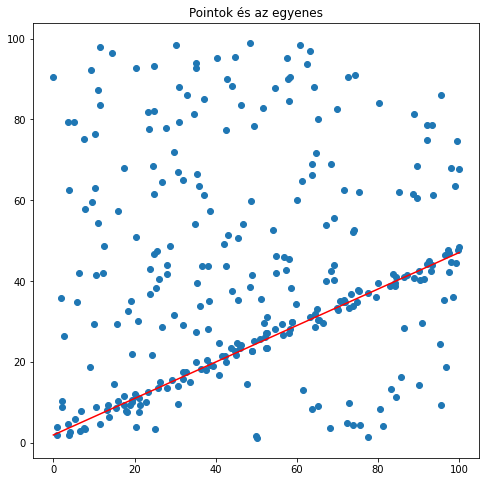

In [46]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot()
ax.scatter(x, y)
ax.plot([0,100], [-l[2] / l[1], -l[0] / l[1] * 100 - l[2] / l[1]], 'r', label='original line')
_ = ax.set_title('Pointok és az egyenes')

In [47]:
best_n = 0          # number of points on the best fit line so far
best_i = 0          # iteration index of best fit line so far
best_inliers = np.array([]) # indices of inliers of the best fit line so far
for i in np.arange(rep):
    # select two random points
    p = []  # list of random indices for points
    while len(p) != 2:
        p = list(set(np.random.randint(n+k, size=2))) # remove repeated random integers
    p1 = points[p]  # randomly selected points
    x1 = p1[:,0]    # x coordinates
    y1 = p1[:,1]    # y coordinates
    # line equation from the two points using homogenouos coordinates
    l1 = np.array([y1[0] - y1[1], x1[1] - x1[0], x1[0] * y1[1] - x1[1] * y1[0]])
    l1 = l1 / sqrt(l1[0]**2 + l1[1]**2)     # normalize
    # select close points
    inliers = points[np.abs(np.dot(points, l1)) < tolerance]
    if inliers.shape[0] > best_n:
        # better solution found
        best_n = inliers.shape[0]
        best_i = i
        best_inliers = inliers.copy()
        best_line = l1.copy()
print(f'Legjobb megoldás {best_i} ismétlés után, pontok száma az egyenesen: {best_n}  egyenes: {best_line}')

Legjobb megoldás 595 ismétlés után, pontok száma az egyenesen: 113  egyens: [ 0.41358096 -0.91046735  1.4446422 ]


Futtasa többször a fenti kódblokkot és vegye észre az egyes egyenletének változását.

Végül jelenítsük meg a legjobban illeszkedő egyenest.

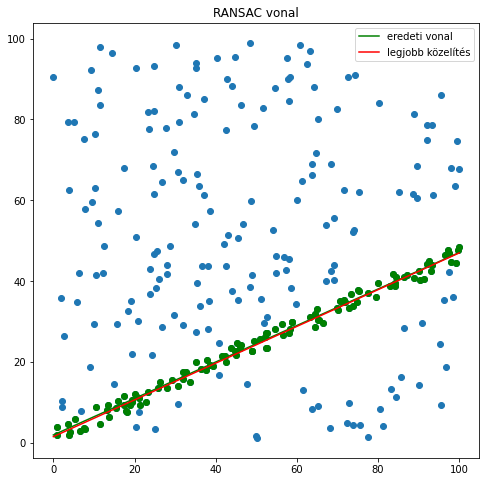

In [48]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot()
ax.scatter(x, y)
ax.scatter(best_inliers[:,0], best_inliers[:,1], c='g')
ax.plot([0,100], [-l[2] / l[1], -l[0] / l[1] * 100 - l[2] / l[1]], 'g', label='eredeti vonal')
ax.plot([0,100], [-best_line[2] / best_line[1], -best_line[0] / best_line[1] * 100 - best_line[2] / best_line[1]], 'r', label='legjobb közelítés')
ax.legend()
_ = ax.set_title('RANSAC vonal')